# Дисперсионный анализ

---

**Дисперсионный анализ** является наиболее общим методом сравнения средних. В дисперсионном анализе можно исследовать зависимость количественных признаков (зависимых переменных) от одного или нескольких качественных признаков (факторов).

В качестве зависимых переменных выбраны переменные study_hours_week и final_exam_score, а в качестве категориальных – teaching_quality и gender.

Ниже представлена таблица статистических эффектов, являющихся последствиями разбиения выборки на группы. Для выделенных красным цветом эффектов можно утверждать, что при разбиении на группы по данному эффекту наверняка будут группы со статистически значимыми отличиями средних.

In [1]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA

df = pd.read_csv("../data/student_perfomance_sample.csv")

maov = MANOVA.from_formula("study_hours_week + final_exam_score ~ teaching_quality * gender", data=df)
res = maov.mv_test()
effects = ["Intercept", "teaching_quality", "gender", "teaching_quality:gender"]
rows = []
for eff in effects:
    sub = res.results[eff]["stat"]
    wilks = sub.loc["Wilks' lambda", "Value"]
    Fval  = sub.loc["Wilks' lambda", "F Value"]
    pval  = sub.loc["Wilks' lambda", "Pr > F"]
    rows.append([eff, wilks, Fval, pval])

manova_table = pd.DataFrame(rows, columns=["Эффект", "Лямбда Уилкса", "F", "p-значение"])
manova_table.style.apply(lambda row: ['color: red; font-weight: bold' * len(row) if row["p-значение"] < 0.05 else '' for _ in manova_table.columns], axis=1)

,Эффект,Лямбда Уилкса,F,p-значение
0,Intercept,0.019875,23104.232671,0.000000
1,teaching_quality,0.994832,1.215299,0.302235
2,gender,0.998083,0.899923,0.406952
3,teaching_quality:gender,0.998116,0.441924,0.778367


В представленной ниже таблице расположены значения средних зависимых переменных study_hours_week и final_exam_score и другими статистиками в группах, соответствующих трем уровням категориального предиктора teaching_quality – Low, Medium, High.

In [2]:
import numpy as np
from scipy.stats import t

def ci_95(series):
    series = series.dropna()
    n = len(series)
    mean = series.mean()
    se = series.std(ddof=1) / np.sqrt(n)
    t_crit = t.ppf(0.975, df=n-1)
    lower = mean - t_crit * se
    upper = mean + t_crit * se
    return mean, lower, upper, n

rows = []
for level, group in df.groupby("teaching_quality"):
    m1, low1, high1, n_obs = ci_95(group["study_hours_week"])
    m2, low2, high2, _ = ci_95(group["final_exam_score"])
    rows.append([level, m1, low1, high1, m2, low2, high2, n_obs])

result_table = pd.DataFrame(
    rows,
    columns=[
        "Качество преподавания",
        "Часы учебы/нед среднее", "Часы учебы/нед -95,00%", "Часы учебы/нед +95,00%",
        "Итоговый балл среднее", "Итоговый балл -95,00%", "Итоговый балл +95,00%",
        "N"
    ]
)
result_table

,Качество преподавания,Часы учебы/нед среднее,"Часы учебы/нед -95,00%","Часы учебы/нед +95,00%",Итоговый балл среднее,"Итоговый балл -95,00%","Итоговый балл +95,00%",N
0,High,19.802768,19.113621,20.491915,67.321799,66.905746,67.737853,289
1,Low,20.406593,19.324898,21.488289,66.296703,65.624730,66.968677,91
2,Medium,20.127660,19.619743,20.635577,67.283688,66.960164,67.607212,564


На рисунках ниже представлены графики средних для переменных study_hours_week и final_exam_score.

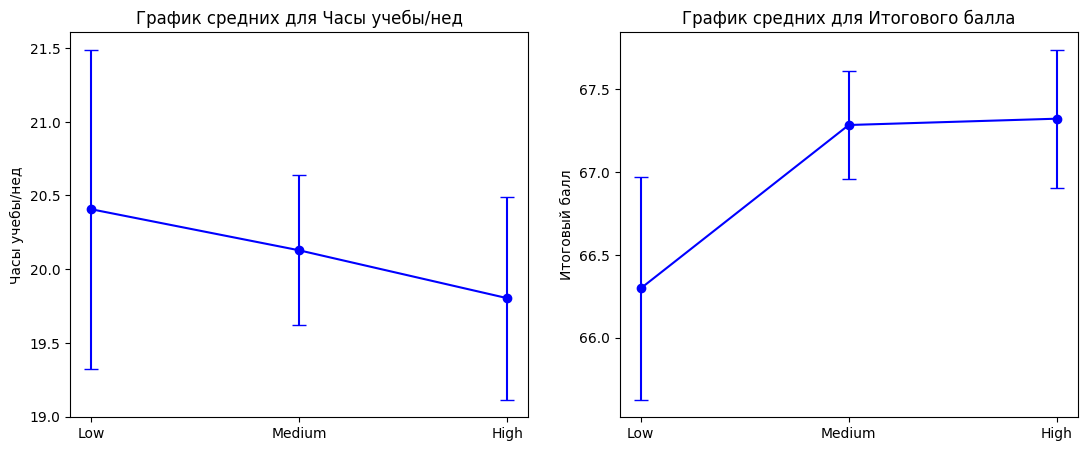

In [3]:
import matplotlib.pyplot as plt

order = ["Low", "Medium", "High"]
plot_df = result_table.set_index("Качество преподавания").loc[order]

means1 = plot_df["Часы учебы/нед среднее"]
lower1 = plot_df["Часы учебы/нед -95,00%"]
upper1 = plot_df["Часы учебы/нед +95,00%"]

means2 = plot_df["Итоговый балл среднее"]
lower2 = plot_df["Итоговый балл -95,00%"]
upper2 = plot_df["Итоговый балл +95,00%"]

x = np.arange(len(order))
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True)
ax = axes[0]
ax.errorbar(x, means1, yerr=[means1 - lower1, upper1 - means1], fmt='o-', color='blue', capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.set_title("График средних для Часы учебы/нед")
ax.set_ylabel("Часы учебы/нед")
ax = axes[1]
ax.errorbar(x, means2, yerr=[means2 - lower2, upper2 - means2], fmt='o-', color='blue', capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(order)
ax.set_title("График средних для Итогового балла")
ax.set_ylabel("Итоговый балл")
plt.show()

Из графиков и таблицы видно, что среднее количество часов, потраченных в неделю на учебу у учащихся школ с низким качеством преподавания превосходит количество часов со средним качеством преподавания и еще больше превосходит с высоким. С итоговым баллом наоборот: средний итоговый балл у учащихся с низким качеством преподавания ниже, чем у учащихся со средним и высоким качеством преподавания.

*Первый полученный результат* объясняется тем, что учащиеся вынуждены больше времени тратить на самостоятельное изучение материала, чтобы компенсировать недостатки обучения.

*Второй полученный результат* вполне логичен: высокое преподавание позволяет ученикам лучше понять и усвоить материал, что приводит к лучшим результатам на экзамене.